In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

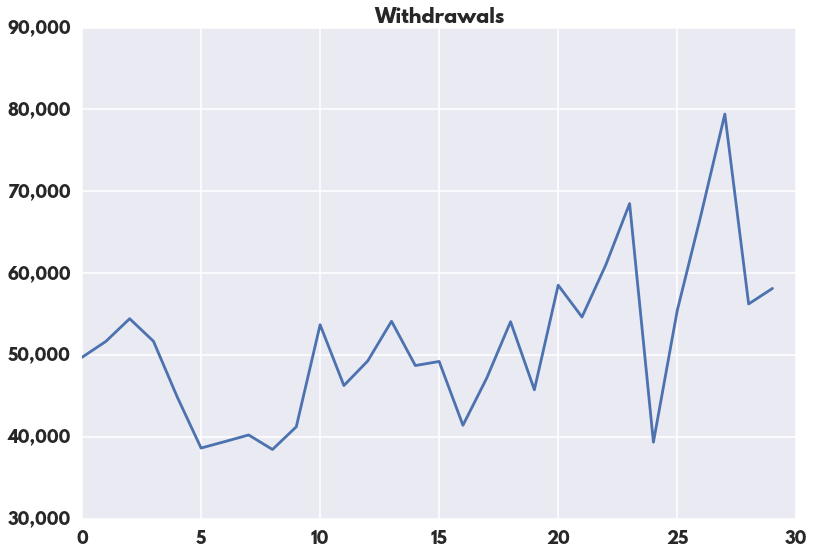

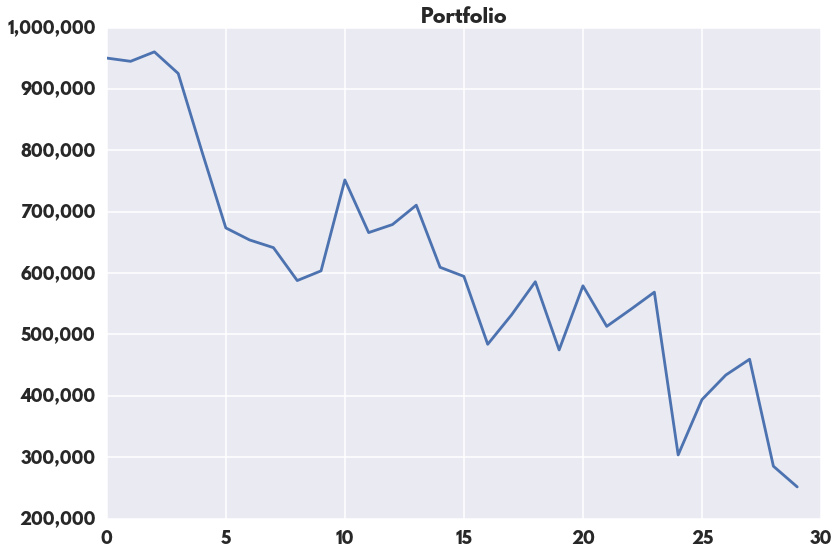

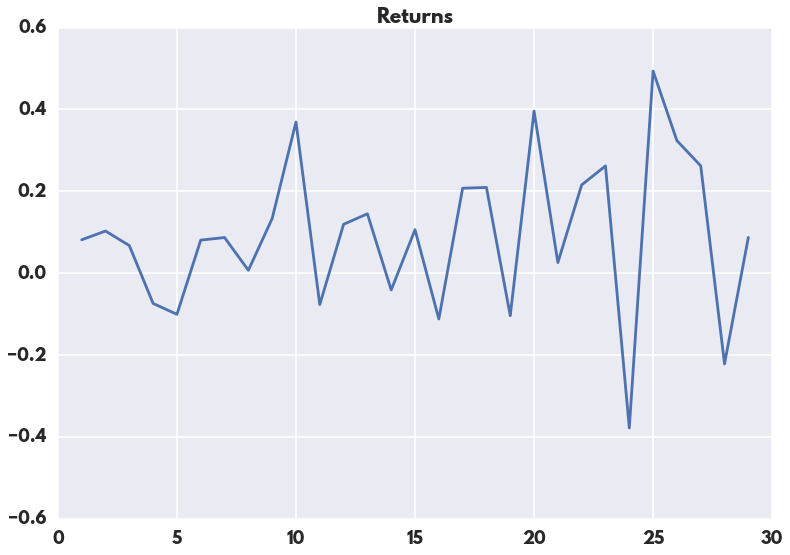

In [2]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [3]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['0.08',
 '0.10',
 '0.07',
 '-0.07',
 '-0.10',
 '0.08',
 '0.09',
 '0.01',
 '0.13',
 '0.37',
 '-0.08',
 '0.12',
 '0.14',
 '-0.04',
 '0.11',
 '-0.11',
 '0.21',
 '0.21',
 '-0.10',
 '0.40',
 '0.03',
 '0.22',
 '0.26',
 '-0.38',
 '0.49',
 '0.32',
 '0.26',
 '-0.22',
 '0.09']


In [4]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [5]:
iters = 100
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))

In [6]:
for i in (EM, ECM, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.97
90th percentile income 5.90984973593
50th percentile income 4.47385550969
10th percentile income 2.90725676497
5th percentile income 2.73180471885
1st percentile income 0.0177613934572

Success rate 0.96
90th percentile income 5.35238359054
50th percentile income 4.2179244703
10th percentile income 3.05235918647
5th percentile income 2.75228140994
1st percentile income 0.0196798967013

Success rate 1.0
90th percentile income 6.24527503802
50th percentile income 4.42330024959
10th percentile income 2.33338695636
5th percentile income 2.00864055449
1st percentile income 1.60280107525



In [7]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [8]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.021940617901441226
stocks 0.03134514418892224
bonds 0.039079831259360896
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.036586  0.019406  0.224644  0.024151   0.043805
1   0.036586  0.039613  0.016011 -0.142623  0.017147   0.044882
2   0.039613  0.039184  0.019925 -0.138018 -0.003987  -0.003223
3   0.039184  0.044138  0.039553 -0.057104  0.016477   0.061938
4   0.044138  0.027829  0.000000 -0.299398  0.077544   0.001696
5   0.027829  0.026086  0.003336  0.089994  0.033054   0.063515
6   0.026086  0.029824  0.026096  0.028741  0.052971   0.009903
7   0.029824  0.011031  0.000000  0.092621  0.126690  -0.045620
8   0.011031  0.020643  0.002595 -0.012800  0.051727   0.023991
9   0.020643  0.014347  0.000000  0.150147  0.038132   0.058498
10  0.014347  0.010000  0.006578 -0.109125  0.072293   0.021339
11  0.010000  0.010000  0.003031  0.006526  0.086813   0.030044
12  0.010000  0.0

In [9]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [10]:
s.median()

0.048

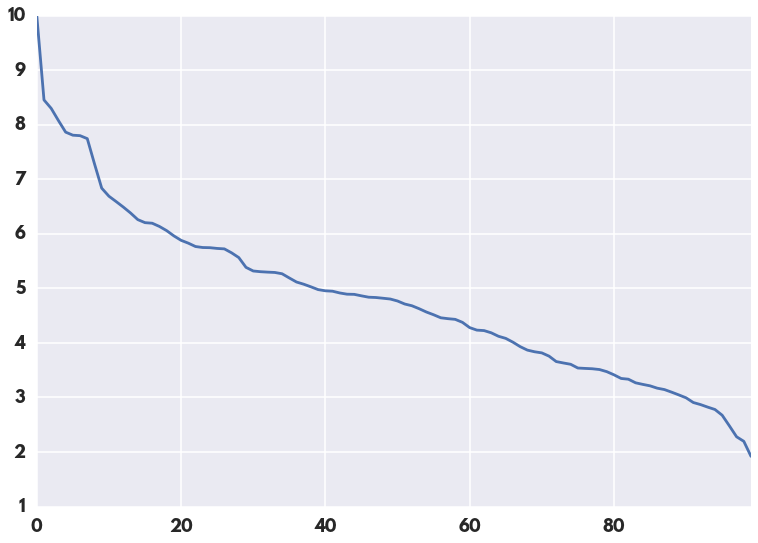

In [11]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [29]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 10000
successes = 0
for i in range(iters):
    final_age = mortality.gen_age(survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.033')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

0.9485
